In [41]:
import pandas as pd 
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import sklearn 
import seaborn as sns 
import os 
from tqdm import tqdm 
from glob import glob 
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.svm import SVC
from sklearn.decomposition import PCA 
from sklearn.datasets import load_digits,load_iris
from sklearn.metrics import classification_report

## 데이터 로드 및 전처리 

In [67]:
def data_load():
    #데이터 로드 
    data = load_iris() 
    df = pd.DataFrame(data.data)
    df.columns = data['feature_names']
    df['class'] = data['target']
    df = df.sample(frac=1,random_state=42).reset_index(drop=True) #shuffle 
    return df 

def train_split(X,Y):
    idx = int(len(X)*0.8)
    train_x = X[:idx]
    train_y = Y[:idx]
    test_x = X[idx:]
    test_y = Y[idx:]
    return train_x, train_y, test_x, test_y


def data_preprocess(df):
    class_list = ['sepal length (cm)','sepal width (cm)']
    X = df.drop(columns='class')[class_list].to_numpy()
    Y = df['class'].to_numpy()


    train_x, train_y, test_x, test_y = train_split(X,Y)
    return (X,Y),(train_x, train_y, test_x, test_y)


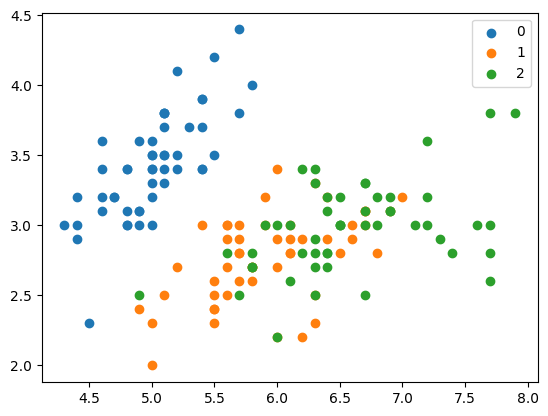

In [68]:
df = data_load() 

(X,Y),(train_x, train_y, test_x, test_y) = data_preprocess(df)


for i in np.unique(df['class']):
    plt_x = X[np.where(Y == i )[0]] 
    plt.scatter(plt_x[:,0],plt_x[:,1],label=i)
    plt.legend()
plt.show()


# 모델링 

## 커널에 따른 차이 비교 

In [104]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier,kernel, resolution=0.02):
    
    # 마커와 컬러맵을 설정합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 결정 경계를 그립니다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.title(f'{kernel}')
    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                   y=X[y == cl, 1],
                   alpha=0.8,
                   c=colors[idx],
                   marker=markers[idx],
                   label=cl,
                   edgecolor='black')
    plt.show()

def model_result(kernel,data):
    (train_x, train_y, test_x, test_y) = data 

    model = SVC(C=1,kernel=kernel)
    model.fit(train_x,train_y)
    y_pred = model.predict(test_x)
    print(f'          테스트 데이터 Metrics : {kernel} \n {classification_report(test_y,y_pred)}')
    plot_decision_regions(test_x,test_y,model,kernel)

          테스트 데이터 Metrics : linear 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.70      0.64      0.67        11
           2       0.69      0.75      0.72        12

    accuracy                           0.77        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.77      0.77      0.77        30



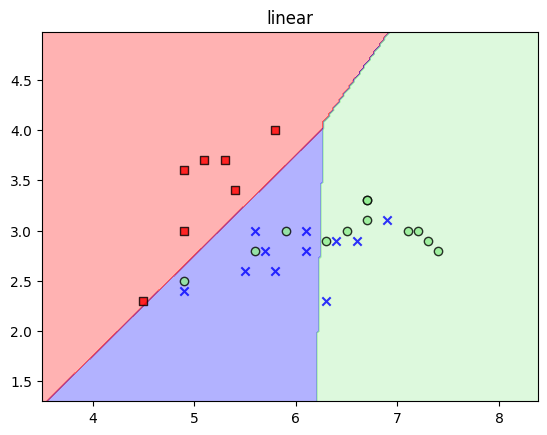

          테스트 데이터 Metrics : rbf 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.70      0.64      0.67        11
           2       0.69      0.75      0.72        12

    accuracy                           0.77        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.77      0.77      0.77        30



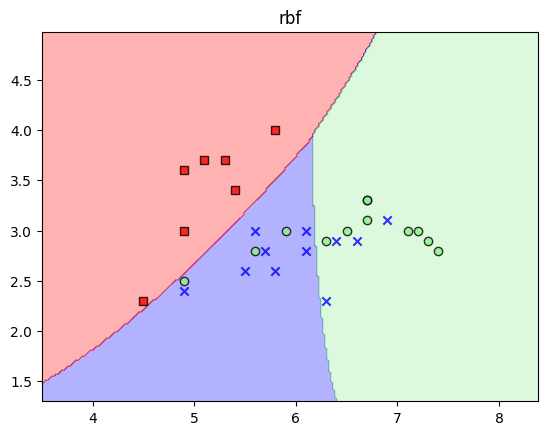

          테스트 데이터 Metrics : sigmoid 
               precision    recall  f1-score   support

           0       0.23      1.00      0.38         7
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        12

    accuracy                           0.23        30
   macro avg       0.08      0.33      0.13        30
weighted avg       0.05      0.23      0.09        30



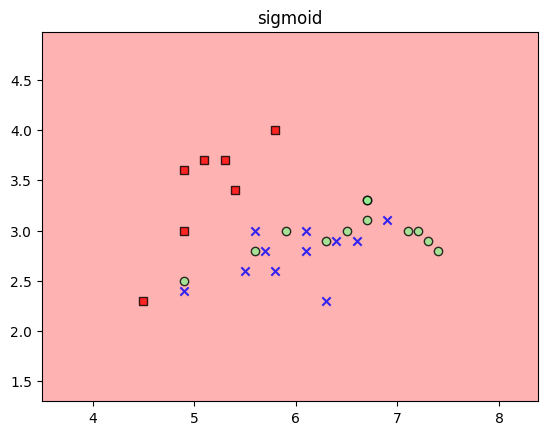

          테스트 데이터 Metrics : poly 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.70      0.64      0.67        11
           2       0.69      0.75      0.72        12

    accuracy                           0.77        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.77      0.77      0.77        30



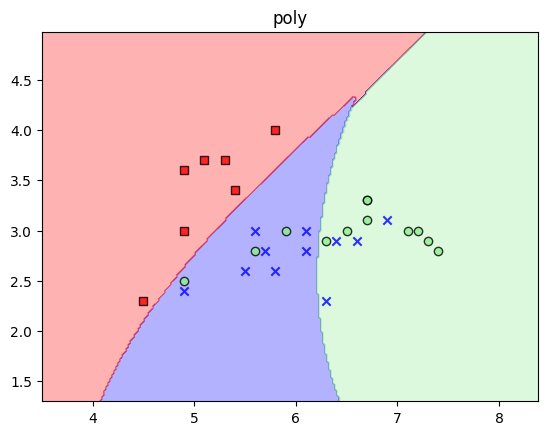

In [105]:
data = (train_x, train_y, test_x, test_y) 

for kernel in ['linear','rbf','sigmoid','poly']:
    model_result(kernel,data)

## NN 모델과 비교 

In [178]:
import torch 
import torch.nn as nn 

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Sequential(
                                    nn.Linear(2,10),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(10)
                                    )
        self.fc1_1 = nn.Sequential(  
                                    nn.Linear(10,10),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(10))                                
        self.fc2 = nn.Linear(10,3)
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc1_1(x)
        x = self.fc2(x)
        return x 


In [181]:
device = 'cuda:0'
NN = Model().to(device)
optimizer = torch.optim.Adam(NN.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 20000

train_x, train_y = torch.tensor(train_x).type(torch.float).to(device),torch.tensor(train_y).type(torch.float).to(device)

for epoch in range(num_epochs):
    NN.train()
    optimizer.zero_grad()
    y_pred = NN(train_x)
    loss = criterion(y_pred,train_y.reshape(-1).type(torch.long))
    loss.backward()
    optimizer.step()
    
    print(loss)

tensor(0.9981, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9825, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9683, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9547, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9418, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9290, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9166, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9051, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8940, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8831, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8727, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8626, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8524, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8331, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8239, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8149, device='cuda:0', grad_fn=

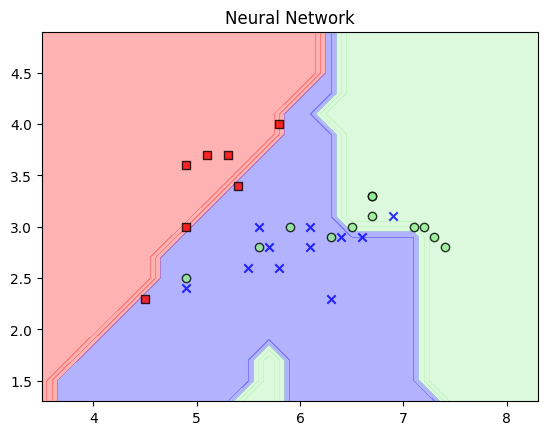

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.55      0.75      0.63         8
           2       0.75      0.64      0.69        14

    accuracy                           0.73        30
   macro avg       0.77      0.76      0.75        30
weighted avg       0.76      0.73      0.74        30



In [182]:
def plot_decision_boundary(X,y,classifier,kernel,resolution=0.2):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    #결정경계
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    input_x = np.array([xx1.ravel(), xx2.ravel()]).T
    Z = NN(torch.tensor(input_x).type(torch.float).to(device))
    y_pred = torch.argmax(Z,axis=1)
    Z = y_pred.detach().cpu().numpy().reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.title('Neural Network')
    
    #샘플의 산점도 
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
    plt.show()

y_pred = torch.argmax(NN(torch.tensor(test_x).to(device).type(torch.float)),axis=1).detach().cpu().numpy()
print(classification_report(y_pred,test_y))